# Neural Network Model with Comprehensive Evaluation Framework

This notebook implements a structured approach for neural network experimentation with:
- Standardized model experimentation framework
- Comprehensive hyperparameter optimization
- Cross-validation and statistical validation
- Publication-ready visualizations
- Demographic bias analysis

**Dataset:** Titanic Enhanced Feature Set (891 samples, 36 features)  
**Target:** Binary survival classification  
**Framework:** TensorFlow/Keras with scikit-learn integration

In [34]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import warnings
import json
import joblib
from datetime import datetime
import os
warnings.filterwarnings('ignore')

# Scikit-learn components
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, matthews_corrcoef,
    balanced_accuracy_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, brier_score_loss
)

# Deep learning framework
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, regularizers, optimizers, metrics

# Statistical analysis
from scipy import stats

# Configuration
tf.random.set_seed(42)
np.random.seed(42)
pd.set_option('display.max_columns', None)

# Plotting configuration for publication quality
plt.rcParams.update({
    'figure.figsize': (10, 8),
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16,
    'axes.grid': True,
    'grid.alpha': 0.3
})

print("Environment initialized successfully")
print(f"TensorFlow version: {tf.__version__}")
print(f"Available GPUs: {len(tf.config.list_physical_devices('GPU'))}")

Environment initialized successfully
TensorFlow version: 2.20.0
Available GPUs: 0


In [35]:
class ModelExperiment:
    """
    Standardized framework for machine learning experimentation.
    
    This class provides a structured approach to model development including:
    - Hyperparameter optimization
    - Cross-validation
    - Model training and evaluation
    - Error analysis and reporting
    - Automated result persistence
    """
    
    def __init__(self, model_name, random_state=42):
        self.model_name = model_name
        self.random_state = random_state
        self.results = {}
        self.best_model = None
        self.best_params = None
        self.training_history = None
        self.experiment_timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        
        print(f"Initialized {model_name} experiment (ID: {self.experiment_timestamp})")
    
    def run_experiment(self, X_train, y_train, X_val, y_val, demographic_data=None):
        """
        Execute complete machine learning experiment pipeline.
        
        Parameters:
        -----------
        X_train, y_train : array-like
            Training data and labels
        X_val, y_val : array-like
            Validation data and labels
        demographic_data : dict, optional
            Demographic information for bias analysis
            
        Returns:
        --------
        dict : Complete experiment results
        """
        print(f"\n{'='*60}")
        print(f"EXECUTING {self.model_name.upper()} EXPERIMENT")
        print(f"{'='*60}")
        
        # Store data characteristics
        self.results['data_info'] = {
            'train_samples': len(X_train),
            'val_samples': len(X_val),
            'features': X_train.shape[1],
            'train_class_distribution': np.bincount(y_train).tolist(),
            'val_class_distribution': np.bincount(y_val).tolist()
        }
        
        # 1. Hyperparameter optimization
        self._hyperparameter_search(X_train, y_train)
        
        # 2. Cross-validation
        self._cross_validation(X_train, y_train)
        
        # 3. Model training
        self._train_best_model(X_train, y_train)
        
        # 4. Model evaluation
        self._evaluate_model(X_val, y_val)
        
        # 5. Error analysis
        self._error_analysis(X_val, y_val, demographic_data)
        
        # 6. Generate visualizations
        self._generate_publication_plots(X_val, y_val, demographic_data)
        
        # 7. Save results
        self._save_results()
        
        print(f"\nExperiment completed successfully!")
        print(f"Results saved with timestamp: {self.experiment_timestamp}")
        
        return self.results
    
    def _hyperparameter_search(self, X_train, y_train):
        """
        1. Hyperparameter optimization using grid/random search
        """
        print("\n1. HYPERPARAMETER OPTIMIZATION")
        print("-" * 40)
        
        # Define search space
        param_space = {
            'hidden_layers': [[128, 64]],
            'dropout_rate': [0.20, 0.22, 0.25],
            'learning_rate': [0.0004, 0.0005, 0.0006],
            'l2_reg': [1e-4, 2.5e-4, 5e-4, 7.5e-4, 1e-3]
        }
        
        # Generate parameter combinations
        param_combinations = []
        for hidden_layers in param_space['hidden_layers']:
            for dropout_rate in param_space['dropout_rate']:
                for learning_rate in param_space['learning_rate']:
                    for l2_reg in param_space['l2_reg']:
                        param_combinations.append({
                            'hidden_layers': hidden_layers,
                            'dropout_rate': dropout_rate,
                            'learning_rate': learning_rate,
                            'l2_reg': l2_reg
                        })
        
        print(f"Search space: {len(param_combinations)} configurations")
        
        # Execute grid search
        best_score = 0
        search_results = []
        
        # Class weights for imbalanced data
        neg, pos = np.bincount(y_train)
        total = neg + pos
        class_weight = {0: total/(2*neg), 1: total/(2*pos)}
        
        for i, params in enumerate(param_combinations[:15]):  # Limit for computational efficiency
            print(f"\nConfiguration {i+1}/15: {params}")
            
            try:
                # Create and train model
                model = self._create_neural_network(X_train.shape[1], **params)
                
                early_stopping = callbacks.EarlyStopping(
                    monitor='val_auc', mode='max', patience=10,
                    restore_best_weights=True, verbose=0
                )
                
                history = model.fit(
                    X_train, y_train,
                    validation_split=0.2,
                    epochs=100,
                    batch_size=32,
                    class_weight=class_weight,
                    callbacks=[early_stopping],
                    verbose=0
                )
                
                # Evaluate configuration
                val_auc = max(history.history['val_auc'])
                search_results.append({
                    'params': params,
                    'val_auc': val_auc,
                    'epochs_trained': len(history.history['loss'])
                })
                
                print(f"Validation AUC: {val_auc:.4f}")
                
                if val_auc > best_score:
                    best_score = val_auc
                    self.best_params = params
                    print(f"✓ New best configuration!")
                    
            except Exception as e:
                print(f"✗ Configuration failed: {e}")
                continue
        
        # Store search results
        self.results['hyperparameter_search'] = {
            'search_results': search_results,
            'best_params': self.best_params,
            'best_score': best_score,
            'total_configurations': len(search_results)
        }
        
        print(f"\nOptimal configuration found:")
        print(f"Parameters: {self.best_params}")
        print(f"Validation AUC: {best_score:.4f}")
    
    def _cross_validation(self, X_train, y_train):
        """
        2. Stratified k-fold cross-validation
        """
        print("\n2. CROSS-VALIDATION ANALYSIS")
        print("-" * 40)
        
        # 5-fold stratified cross-validation
        cv_folds = 5
        skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=self.random_state)
        
        cv_scores = {
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': [],
            'roc_auc': []
        }
        
        print(f"Executing {cv_folds}-fold stratified cross-validation...")
        
        for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
            print(f"Fold {fold + 1}/{cv_folds}...", end=' ')
            
            # Split data
            X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
            y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
            
            # Train fold model
            fold_model = self._create_neural_network(X_train.shape[1], **self.best_params)
            
            early_stopping = callbacks.EarlyStopping(
                monitor='val_loss', patience=10, restore_best_weights=True, verbose=0
            )
            
            # Class weights
            neg, pos = np.bincount(y_fold_train)
            total = neg + pos
            class_weight = {0: total/(2*neg), 1: total/(2*pos)}
            
            fold_model.fit(
                X_fold_train, y_fold_train,
                validation_data=(X_fold_val, y_fold_val),
                epochs=50,
                batch_size=32,
                class_weight=class_weight,
                callbacks=[early_stopping],
                verbose=0
            )
            
            # Evaluate fold
            y_pred_proba = fold_model.predict(X_fold_val, verbose=0).ravel()
            y_pred = (y_pred_proba >= 0.5).astype(int)
            
            # Calculate metrics
            cv_scores['accuracy'].append(accuracy_score(y_fold_val, y_pred))
            cv_scores['precision'].append(precision_score(y_fold_val, y_pred, zero_division=0))
            cv_scores['recall'].append(recall_score(y_fold_val, y_pred, zero_division=0))
            cv_scores['f1'].append(f1_score(y_fold_val, y_pred, zero_division=0))
            cv_scores['roc_auc'].append(roc_auc_score(y_fold_val, y_pred_proba))
            
            print(f"AUC: {cv_scores['roc_auc'][-1]:.3f}")
        
        # Calculate statistics
        cv_statistics = {}
        for metric, scores in cv_scores.items():
            cv_statistics[metric] = {
                'mean': np.mean(scores),
                'std': np.std(scores),
                'ci_95': stats.t.interval(0.95, len(scores)-1, 
                                        loc=np.mean(scores), 
                                        scale=stats.sem(scores))
            }
        
        self.results['cross_validation'] = {
            'cv_scores': cv_scores,
            'cv_statistics': cv_statistics,
            'n_folds': cv_folds
        }
        
        print(f"\nCross-validation results:")
        for metric, stats_dict in cv_statistics.items():
            print(f"{metric.upper()}: {stats_dict['mean']:.4f} ± {stats_dict['std']:.4f} "
                  f"(95% CI: [{stats_dict['ci_95'][0]:.4f}, {stats_dict['ci_95'][1]:.4f}])")
    
    def _train_best_model(self, X_train, y_train):
        """
        3. Train final model with optimal hyperparameters
        """
        print("\n3. FINAL MODEL TRAINING")
        print("-" * 40)
        
        # Create final model
        self.best_model = self._create_neural_network(X_train.shape[1], **self.best_params)
        
        # Enhanced callbacks
        model_callbacks = [
            callbacks.EarlyStopping(
                monitor='val_auc', mode='max', patience=15,
                restore_best_weights=True, verbose=1
            ),
            callbacks.ReduceLROnPlateau(
                monitor='val_auc', mode='max', factor=0.5,
                patience=8, verbose=1, min_lr=1e-7
            )
        ]
        
        # Class weights
        neg, pos = np.bincount(y_train)
        total = neg + pos
        class_weight = {0: total/(2*neg), 1: total/(2*pos)}
        
        print(f"Training with class weights: {class_weight}")
        
        # Train model
        self.training_history = self.best_model.fit(
            X_train, y_train,
            validation_split=0.2,
            epochs=150,
            batch_size=32,
            class_weight=class_weight,
            callbacks=model_callbacks,
            verbose=1
        )
        
        # Store training metrics
        self.results['training'] = {
            'final_epochs': len(self.training_history.history['loss']),
            'best_val_auc': max(self.training_history.history['val_auc']),
            'training_time': 'completed',
            'class_weights': class_weight
        }
        
        print(f"Training completed after {len(self.training_history.history['loss'])} epochs")
        print(f"Best validation AUC: {max(self.training_history.history['val_auc']):.4f}")
    
    def _evaluate_model(self, X_val, y_val):
        """
        4. Comprehensive model evaluation on validation set
        """
        print("\n4. MODEL EVALUATION")
        print("-" * 40)
        
        # Generate predictions
        y_pred_proba = self.best_model.predict(X_val, verbose=0).ravel()
        y_pred = (y_pred_proba >= 0.5).astype(int)
        
        # Calculate comprehensive metrics
        evaluation_metrics = {
            'accuracy': accuracy_score(y_val, y_pred),
            'precision': precision_score(y_val, y_pred, zero_division=0),
            'recall': recall_score(y_val, y_pred, zero_division=0),
            'f1_score': f1_score(y_val, y_pred, zero_division=0),
            'roc_auc': roc_auc_score(y_val, y_pred_proba),
            'pr_auc': average_precision_score(y_val, y_pred_proba),
            'matthews_corrcoef': matthews_corrcoef(y_val, y_pred),
            'balanced_accuracy': balanced_accuracy_score(y_val, y_pred),
            'brier_score': brier_score_loss(y_val, y_pred_proba)
        }
        
        # Confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        
        # Calibration metrics
        calibration_metrics = self._calculate_calibration_metrics(y_val, y_pred_proba)
        
        self.results['evaluation'] = {
            'metrics': evaluation_metrics,
            'confusion_matrix': cm.tolist(),
            'calibration': calibration_metrics,
            'predictions': {
                'probabilities': y_pred_proba.tolist(),
                'binary_predictions': y_pred.tolist()
            }
        }
        
        print("Validation set performance:")
        for metric, value in evaluation_metrics.items():
            print(f"{metric.replace('_', ' ').title()}: {value:.4f}")
        
        print(f"\nConfusion Matrix:")
        print(f"[[TN={cm[0,0]:3d}, FP={cm[0,1]:3d}]")
        print(f" [FN={cm[1,0]:3d}, TP={cm[1,1]:3d}]]")
    
    def _error_analysis(self, X_val, y_val, demographic_data=None):
        """
        5. Detailed error analysis and demographic bias assessment
        """
        print("\n5. ERROR ANALYSIS")
        print("-" * 40)
        
        # Generate predictions
        y_pred_proba = self.best_model.predict(X_val, verbose=0).ravel()
        y_pred = (y_pred_proba >= 0.5).astype(int)
        
        # Basic error analysis
        errors = y_val != y_pred
        error_indices = np.where(errors)[0]
        
        error_analysis = {
            'total_errors': int(errors.sum()),
            'error_rate': float(errors.mean()),
            'false_positive_rate': float(((y_pred == 1) & (y_val == 0)).sum() / (y_val == 0).sum()),
            'false_negative_rate': float(((y_pred == 0) & (y_val == 1)).sum() / (y_val == 1).sum())
        }
        
        # Demographic bias analysis
        if demographic_data:
            demographic_analysis = {}
            
            for group_name, group_data in demographic_data.items():
                if len(group_data) == len(y_val):
                    group_analysis = self._analyze_demographic_group(
                        y_val, y_pred, y_pred_proba, group_data, group_name
                    )
                    demographic_analysis[group_name] = group_analysis
            
            error_analysis['demographic_analysis'] = demographic_analysis
        
        self.results['error_analysis'] = error_analysis
        
        print(f"Total prediction errors: {error_analysis['total_errors']}/{len(y_val)} "
              f"({error_analysis['error_rate']:.1%})")
        print(f"False positive rate: {error_analysis['false_positive_rate']:.4f}")
        print(f"False negative rate: {error_analysis['false_negative_rate']:.4f}")
        
        if demographic_data:
            print(f"\nDemographic bias analysis completed for {len(demographic_analysis)} groups")
    


    def _save_results(self):
        """
        6. Save model, results, and artifacts
        """
        print("\n6. SAVING RESULTS")
        print("-" * 40)

        # --- Crear carpetas si no existen ---
        models_dir = "models"
        results_dir = "results"
        os.makedirs(models_dir, exist_ok=True)
        os.makedirs(results_dir, exist_ok=True)

        # --- Guardar modelo ---
        model_filename = f"{self.model_name}_{self.experiment_timestamp}.h5"
        model_path = os.path.join(models_dir, model_filename)
        self.best_model.save(model_path)

        # --- Guardar resultados ---
        results_filename = f"{self.model_name}_results_{self.experiment_timestamp}.json"
        results_path = os.path.join(results_dir, results_filename)
        
        serializable_results = self._prepare_results_for_json(self.results)
        with open(results_path, 'w') as f:
            json.dump(serializable_results, f, indent=2, default=str)

        # --- Guardar historial de entrenamiento ---
        history_filename = f"{self.model_name}_history_{self.experiment_timestamp}.json"
        history_path = os.path.join(results_dir, history_filename)
        if self.training_history:
            with open(history_path, 'w') as f:
                json.dump(self.training_history.history, f, indent=2, default=str)

        print(f"✓ Model saved: {model_path}")
        print(f"✓ Results saved: {results_path}")
        print(f"✓ History saved: {history_path}")

        return {
            'model_file': model_path,
            'results_file': results_path,
            'history_file': history_path
    }

    
    def _create_neural_network(self, input_dim, hidden_layers=[128, 64], 
                              dropout_rate=0.15, learning_rate=0.0001, l2_reg=1e-4):
        """
        Create neural network architecture
        """
        model = keras.Sequential()
        model.add(layers.Input(shape=(input_dim,)))
        
        # Hidden layers
        for i, units in enumerate(hidden_layers):
            model.add(layers.Dense(
                units, 
                activation='relu',
                kernel_regularizer=regularizers.l2(l2_reg),
                name=f'dense_{i+1}'
            ))
            model.add(layers.BatchNormalization(name=f'batch_norm_{i+1}'))
            model.add(layers.Dropout(dropout_rate, name=f'dropout_{i+1}'))
        
        # Output layer
        model.add(layers.Dense(1, activation='sigmoid', name='output'))
        
        # Compile model
        model.compile(
            optimizer=optimizers.Adam(learning_rate=learning_rate),
            loss='binary_crossentropy',
            metrics=[
                'accuracy',
                metrics.AUC(name='auc'),
                metrics.Precision(name='precision'),
                metrics.Recall(name='recall')
            ]
        )
        
        return model
    
    def _calculate_calibration_metrics(self, y_true, y_proba, n_bins=10):
        """
        Calculate calibration metrics including ECE and Brier score
        """
        # Expected Calibration Error
        bin_boundaries = np.linspace(0, 1, n_bins + 1)
        bin_lowers = bin_boundaries[:-1]
        bin_uppers = bin_boundaries[1:]
        
        ece = 0
        bin_data = []
        
        for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
            in_bin = (y_proba > bin_lower) & (y_proba <= bin_upper)
            prop_in_bin = in_bin.mean()
            
            if prop_in_bin > 0:
                accuracy_in_bin = y_true[in_bin].mean()
                avg_confidence_in_bin = y_proba[in_bin].mean()
                
                ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
                
                bin_data.append({
                    'bin_lower': bin_lower,
                    'bin_upper': bin_upper,
                    'accuracy': accuracy_in_bin,
                    'confidence': avg_confidence_in_bin,
                    'proportion': prop_in_bin,
                    'count': int(in_bin.sum())
                })
        
        return {
            'expected_calibration_error': ece,
            'brier_score': brier_score_loss(y_true, y_proba),
            'bin_data': bin_data
        }
    
    def _analyze_demographic_group(self, y_true, y_pred, y_proba, group_data, group_name):
        """
        Analyze model performance for specific demographic groups
        """
        unique_groups = np.unique(group_data)
        group_analysis = {}
        
        for group in unique_groups:
            mask = group_data == group
            
            if mask.sum() == 0:
                continue
            
            y_true_group = y_true[mask]
            y_pred_group = y_pred[mask]
            y_proba_group = y_proba[mask]
            
            # Calculate metrics for this group
            if len(np.unique(y_true_group)) > 1:  # Both classes present
                group_metrics = {
                    'sample_size': int(mask.sum()),
                    'accuracy': accuracy_score(y_true_group, y_pred_group),
                    'precision': precision_score(y_true_group, y_pred_group, zero_division=0),
                    'recall': recall_score(y_true_group, y_pred_group, zero_division=0),
                    'f1_score': f1_score(y_true_group, y_pred_group, zero_division=0),
                    'roc_auc': roc_auc_score(y_true_group, y_proba_group),
                    'base_rate': float(y_true_group.mean())
                }
            else:
                group_metrics = {
                    'sample_size': int(mask.sum()),
                    'accuracy': accuracy_score(y_true_group, y_pred_group),
                    'base_rate': float(y_true_group.mean()),
                    'note': 'Single class present'
                }
            
            group_analysis[str(group)] = group_metrics
        
        return group_analysis
    
    def _prepare_results_for_json(self, results):
        """
        Convert numpy arrays and other non-serializable objects for JSON
        """
        serializable = {}
        
        for key, value in results.items():
            if isinstance(value, dict):
                serializable[key] = self._prepare_results_for_json(value)
            elif isinstance(value, (np.ndarray, list)):
                serializable[key] = np.array(value).tolist()
            elif isinstance(value, (np.float64, np.float32, np.int64, np.int32)):
                serializable[key] = float(value)
            else:
                serializable[key] = value
        
        return serializable

print("ModelExperiment framework initialized")

ModelExperiment framework initialized


In [36]:

class NeuralNetworkExperiment(ModelExperiment):
    """
    Specialized neural network experiment with publication-quality visualizations
    """
    
    def __init__(self, random_state=42):
        super().__init__("NeuralNetwork_Publication", random_state)
        self.demographic_vars = {
            'Sex': 'Gender',
            'Pclass': 'Socioeconomic Class', 
            'Age_Group': 'Age Group',
            'FamilySize_Category': 'Family Size'
        }
    
    def _generate_publication_plots(self, X_val, y_val, demographic_data=None):
        """
        Generate publication-ready visualizations
        """
        print("\n7. GENERATING PUBLICATION PLOTS")
        print("-" * 40)
        
        # Get predictions
        y_pred_proba = self.best_model.predict(X_val, verbose=0).ravel()
        y_pred = (y_pred_proba >= 0.5).astype(int)
        
        # Create figure with subplots
        fig = plt.figure(figsize=(20, 16))
        
        # 1. Training History
        ax1 = plt.subplot(3, 4, 1)
        self._plot_training_history(ax1)
        
        # 2. ROC Curve
        ax2 = plt.subplot(3, 4, 2)
        self._plot_roc_curve(ax2, y_val, y_pred_proba)
        
        # 3. Precision-Recall Curve
        ax3 = plt.subplot(3, 4, 3)
        self._plot_precision_recall_curve(ax3, y_val, y_pred_proba)
        
        # 4. Confusion Matrix
        ax4 = plt.subplot(3, 4, 4)
        self._plot_confusion_matrix(ax4, y_val, y_pred)
        
        # 5. Calibration Plot
        ax5 = plt.subplot(3, 4, 5)
        self._plot_calibration_curve(ax5, y_val, y_pred_proba)
        
        # 6. Feature Importance (if applicable)
        ax6 = plt.subplot(3, 4, 6)
        self._plot_prediction_distribution(ax6, y_val, y_pred_proba)
        
        # 7-10. Demographic Analysis
        if demographic_data:
            for i, (demo_var, demo_name) in enumerate(self.demographic_vars.items()):
                if demo_var in demographic_data and i < 4:
                    ax = plt.subplot(3, 4, 7 + i)
                    self._plot_demographic_analysis(ax, y_val, y_pred_proba, 
                                                  demographic_data[demo_var], demo_name)
        
        # 11. Cross-validation Results
        ax11 = plt.subplot(3, 4, 11)
        self._plot_cv_results(ax11)
        
        # 12. Hyperparameter Analysis
        ax12 = plt.subplot(3, 4, 12)
        self._plot_hyperparameter_analysis(ax12)
        
        plt.tight_layout()
        
        # Save high-resolution figure
        plots_dir = "plots"
        os.makedirs(plots_dir, exist_ok=True)
        plot_filename = f"{self.model_name}_plots_{self.experiment_timestamp}.png"
        plot_path = os.path.join(plots_dir, plot_filename)
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        print(f"✓ Publication plots saved: {plot_path}")

        plt.show()
    
    def _plot_training_history(self, ax):
        """Plot training and validation metrics over epochs"""
        if not self.training_history:
            return
            
        history = self.training_history.history
        epochs = range(1, len(history['loss']) + 1)
        
        ax.plot(epochs, history['auc'], 'b-', label='Training AUC', linewidth=2)
        ax.plot(epochs, history['val_auc'], 'r-', label='Validation AUC', linewidth=2)
        
        ax.set_xlabel('Epoch')
        ax.set_ylabel('AUC Score')
        ax.set_title('Model Training Progress', fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Mark best epoch
        best_epoch = np.argmax(history['val_auc']) + 1
        best_auc = max(history['val_auc'])
        ax.axvline(best_epoch, color='gray', linestyle='--', alpha=0.7)
        ax.annotate(f'Best: {best_auc:.3f}\nEpoch {best_epoch}', 
                   xy=(best_epoch, best_auc), xytext=(10, 10),
                   textcoords='offset points', fontsize=9,
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
    
    def _plot_roc_curve(self, ax, y_true, y_proba):
        """Plot ROC curve with AUC score"""
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        auc_score = roc_auc_score(y_true, y_proba)
        
        ax.plot(fpr, tpr, 'b-', linewidth=3, label=f'ROC Curve (AUC = {auc_score:.3f})')
        ax.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.7, label='Random Classifier')
        
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC Curve Analysis', fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
    
    def _plot_precision_recall_curve(self, ax, y_true, y_proba):
        """Plot Precision-Recall curve"""
        precision, recall, _ = precision_recall_curve(y_true, y_proba)
        ap_score = average_precision_score(y_true, y_proba)
        
        ax.plot(recall, precision, 'g-', linewidth=3, 
               label=f'PR Curve (AP = {ap_score:.3f})')
        
        # Baseline (random classifier)
        baseline = y_true.sum() / len(y_true)
        ax.axhline(y=baseline, color='k', linestyle='--', alpha=0.7,
                  label=f'Random (AP = {baseline:.3f})')
        
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_title('Precision-Recall Analysis', fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
    
    def _plot_confusion_matrix(self, ax, y_true, y_pred):
        """Plot confusion matrix heatmap"""
        cm = confusion_matrix(y_true, y_pred)
        
        # Normalize for percentage display
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues', ax=ax,
                   xticklabels=['Predicted: No', 'Predicted: Yes'],
                   yticklabels=['Actual: No', 'Actual: Yes'])
        
        ax.set_title('Confusion Matrix\n(Normalized by Row)', fontweight='bold')
        
        # Add counts as text
        for i in range(2):
            for j in range(2):
                ax.text(j+0.5, i+0.7, f'n={cm[i,j]}', 
                       ha='center', va='center', fontsize=10, color='red')
    
    def _plot_calibration_curve(self, ax, y_true, y_proba, n_bins=10):
        """Plot calibration reliability diagram"""
        bin_boundaries = np.linspace(0, 1, n_bins + 1)
        bin_lowers = bin_boundaries[:-1]
        bin_uppers = bin_boundaries[1:]
        
        bin_centers = []
        bin_accuracies = []
        
        for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
            in_bin = (y_proba > bin_lower) & (y_proba <= bin_upper)
            prop_in_bin = in_bin.mean()
            
            if prop_in_bin > 0:
                accuracy_in_bin = y_true[in_bin].mean()
                avg_confidence_in_bin = y_proba[in_bin].mean()
                bin_centers.append(avg_confidence_in_bin)
                bin_accuracies.append(accuracy_in_bin)
        
        # Perfect calibration line
        ax.plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.7, label='Perfect Calibration')
        
        # Actual calibration
        ax.plot(bin_centers, bin_accuracies, 'ro-', linewidth=2, markersize=6,
               label='Model Calibration')
        
        # Calculate ECE
        ece = self.results['evaluation']['calibration']['expected_calibration_error']
        
        ax.set_xlabel('Mean Predicted Probability')
        ax.set_ylabel('Fraction of Positives')
        ax.set_title(f'Calibration Plot\n(ECE = {ece:.3f})', fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
    
    def _plot_prediction_distribution(self, ax, y_true, y_proba):
        """Plot prediction probability distributions by class"""
        # Separate by true class
        neg_probs = y_proba[y_true == 0]
        pos_probs = y_proba[y_true == 1]
        
        # Plot histograms
        ax.hist(neg_probs, bins=20, alpha=0.7, label=f'Negative Class (n={len(neg_probs)})',
               color='red', density=True)
        ax.hist(pos_probs, bins=20, alpha=0.7, label=f'Positive Class (n={len(pos_probs)})',
               color='blue', density=True)
        
        ax.axvline(0.5, color='black', linestyle='--', alpha=0.8, 
                  label='Decision Threshold')
        
        ax.set_xlabel('Predicted Probability')
        ax.set_ylabel('Density')
        ax.set_title('Prediction Distribution\nby True Class', fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    def _plot_demographic_analysis(self, ax, y_true, y_proba, group_data, group_name):
        """Plot performance metrics by demographic group"""
        unique_groups = np.unique(group_data)
        group_aucs = []
        group_names = []
        group_sizes = []
        
        for group in unique_groups:
            mask = group_data == group
            if mask.sum() > 0 and len(np.unique(y_true[mask])) > 1:
                auc = roc_auc_score(y_true[mask], y_proba[mask])
                group_aucs.append(auc)
                group_names.append(str(group))
                group_sizes.append(mask.sum())
        
        if group_aucs:
            colors = plt.cm.Set3(np.linspace(0, 1, len(group_aucs)))
            bars = ax.bar(range(len(group_aucs)), group_aucs, color=colors)
            
            # Add value labels and sample sizes
            for i, (bar, auc, size) in enumerate(zip(bars, group_aucs, group_sizes)):
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                       f'{auc:.3f}\n(n={size})', ha='center', va='bottom', fontsize=9)
            
            ax.set_xticks(range(len(group_names)))
            ax.set_xticklabels(group_names, rotation=45)
            ax.set_ylabel('AUC Score')
            ax.set_title(f'{group_name}\nPerformance', fontweight='bold')
            ax.set_ylim([0, 1])
            ax.grid(True, alpha=0.3)
    
    def _plot_cv_results(self, ax):
        """Plot cross-validation results with confidence intervals"""
        if 'cross_validation' not in self.results:
            return
            
        cv_stats = self.results['cross_validation']['cv_statistics']
        metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
        
        means = [cv_stats[m]['mean'] for m in metrics if m in cv_stats]
        stds = [cv_stats[m]['std'] for m in metrics if m in cv_stats]
        metric_names = [m.replace('_', ' ').title() for m in metrics if m in cv_stats]
        
        if means:
            bars = ax.bar(range(len(means)), means, yerr=stds, 
                         capsize=5, color='skyblue', alpha=0.7)
            
            # Add value labels
            for bar, mean, std in zip(bars, means, stds):
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.01,
                       f'{mean:.3f}±{std:.3f}', ha='center', va='bottom', fontsize=9)
            
            ax.set_xticks(range(len(metric_names)))
            ax.set_xticklabels(metric_names, rotation=45)
            ax.set_ylabel('Score')
            ax.set_title('Cross-Validation Results\n(5-Fold)', fontweight='bold')
            ax.set_ylim([0, 1])
            ax.grid(True, alpha=0.3)
    
    def _plot_hyperparameter_analysis(self, ax):
        """Plot hyperparameter search results"""
        if 'hyperparameter_search' not in self.results:
            return
            
        search_results = self.results['hyperparameter_search']['search_results']
        
        if not search_results:
            return
            
        # Extract AUC scores
        aucs = [r['val_auc'] for r in search_results]
        configs = range(1, len(aucs) + 1)
        
        ax.scatter(configs, aucs, alpha=0.7, s=50, c='orange')
        
        # Highlight best configuration
        best_idx = np.argmax(aucs)
        ax.scatter(configs[best_idx], aucs[best_idx], s=100, c='red', 
                  marker='*', label=f'Best: {aucs[best_idx]:.4f}')
        
        ax.set_xlabel('Configuration ID')
        ax.set_ylabel('Validation AUC')
        ax.set_title('Hyperparameter Search\nResults', fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)

print("NeuralNetworkExperiment class defined")

NeuralNetworkExperiment class defined


In [37]:
# Data Loading and Preprocessing Pipeline
print("LOADING AND PREPROCESSING DATA")
print("=" * 50)

# Load enhanced Titanic dataset
df = pd.read_csv("../Entrega2/data/Titanic_Dataset_Featured.csv")
print(f"Dataset loaded: {df.shape[0]} samples, {df.shape[1]} features")

# Define optimal feature set (from previous analysis)
selected_features = [
    'NameLength_Quintile', 'NameLength_sqrt', 'FamilySize', 'DeckCategory', 'Pclass', 'SibSp',
    'TicketFreq_Category', 'TicketFrequency', 'NameLength_Category', 'Has_Cabin', 'Age_sqrt',
    'IsAlone', 'FamilySize_Category', 'Parch', 'Fare_log', 'CabinDeck', 'Title', 'IsMinor',
    'TicketPrefix', 'FarePerPerson_Quintile', 'Mother', 'Sex'
]

# Prepare feature matrix and target vector
X = df[selected_features].copy()
y = df['Survived'].astype(int)

# Prepare demographic data for bias analysis
demographic_data = {
    'Sex': df['Sex'].values,
    'Pclass': df['Pclass'].values,
    'Age_Group': df['Age_Group'].values if 'Age_Group' in df.columns else None,
    'FamilySize_Category': df['FamilySize_Category'].values
}

# Remove None entries
demographic_data = {k: v for k, v in demographic_data.items() if v is not None}

print(f"Selected features: {len(selected_features)}")
print(f"Class distribution: {dict(zip(*np.unique(y, return_counts=True)))}")
print(f"Demographic groups: {list(demographic_data.keys())}")

# Feature type classification
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"Numeric features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")

LOADING AND PREPROCESSING DATA
Dataset loaded: 891 samples, 36 features
Selected features: 22
Class distribution: {np.int64(0): np.int64(549), np.int64(1): np.int64(342)}
Demographic groups: ['Sex', 'Pclass', 'Age_Group', 'FamilySize_Category']
Numeric features: 12
Categorical features: 10


In [38]:
# Data Preprocessing Pipeline
print("\nCONFIGURING PREPROCESSING PIPELINE")
print("=" * 50)

# Define preprocessing steps
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combined preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, numeric_features),
        ('categorical', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

print("✓ Preprocessing pipeline configured")

# Stratified train-test split
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)

# Split demographic data accordingly
demo_temp = {}
demo_test = {}
demo_train = {}
demo_val = {}

for key, values in demographic_data.items():
    if len(values) == len(df):
        temp_data, test_data = train_test_split(
            values, test_size=0.2, stratify=y, random_state=42
        )
        train_data, val_data = train_test_split(
            temp_data, test_size=0.25, stratify=y_temp, random_state=42
        )
        
        demo_temp[key] = temp_data
        demo_test[key] = test_data
        demo_train[key] = train_data
        demo_val[key] = val_data

# Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

print(f"\n✓ Data preprocessing completed")
print(f"Training set: {X_train_processed.shape}")
print(f"Validation set: {X_val_processed.shape}")
print(f"Test set: {X_test_processed.shape}")
print(f"Final feature dimension: {X_train_processed.shape[1]}")

# Display class distributions
print(f"\nClass distributions:")
print(f"Training: {dict(zip(*np.unique(y_train, return_counts=True)))}")
print(f"Validation: {dict(zip(*np.unique(y_val, return_counts=True)))}")
print(f"Test: {dict(zip(*np.unique(y_test, return_counts=True)))}")


CONFIGURING PREPROCESSING PIPELINE
✓ Preprocessing pipeline configured

✓ Data preprocessing completed
Training set: (534, 76)
Validation set: (178, 76)
Test set: (179, 76)
Final feature dimension: 76

Class distributions:
Training: {np.int64(0): np.int64(329), np.int64(1): np.int64(205)}
Validation: {np.int64(0): np.int64(110), np.int64(1): np.int64(68)}
Test: {np.int64(0): np.int64(110), np.int64(1): np.int64(69)}



NEURAL NETWORK EXPERIMENT EXECUTION
Initialized NeuralNetwork_Publication experiment (ID: 20250831_170008)

EXECUTING NEURALNETWORK_PUBLICATION EXPERIMENT

1. HYPERPARAMETER OPTIMIZATION
----------------------------------------
Search space: 45 configurations

Configuration 1/15: {'hidden_layers': [128, 64], 'dropout_rate': 0.2, 'learning_rate': 0.0004, 'l2_reg': 0.0001}
Validation AUC: 0.8237
✓ New best configuration!

Configuration 2/15: {'hidden_layers': [128, 64], 'dropout_rate': 0.2, 'learning_rate': 0.0004, 'l2_reg': 0.00025}
Validation AUC: 0.8300
✓ New best configuration!

Configuration 3/15: {'hidden_layers': [128, 64], 'dropout_rate': 0.2, 'learning_rate': 0.0004, 'l2_reg': 0.0005}
Validation AUC: 0.8296

Configuration 4/15: {'hidden_layers': [128, 64], 'dropout_rate': 0.2, 'learning_rate': 0.0004, 'l2_reg': 0.00075}
Validation AUC: 0.8356
✓ New best configuration!

Configuration 5/15: {'hidden_layers': [128, 64], 'dropout_rate': 0.2, 'learning_rate': 0.0004, 'l2_reg': 0.001

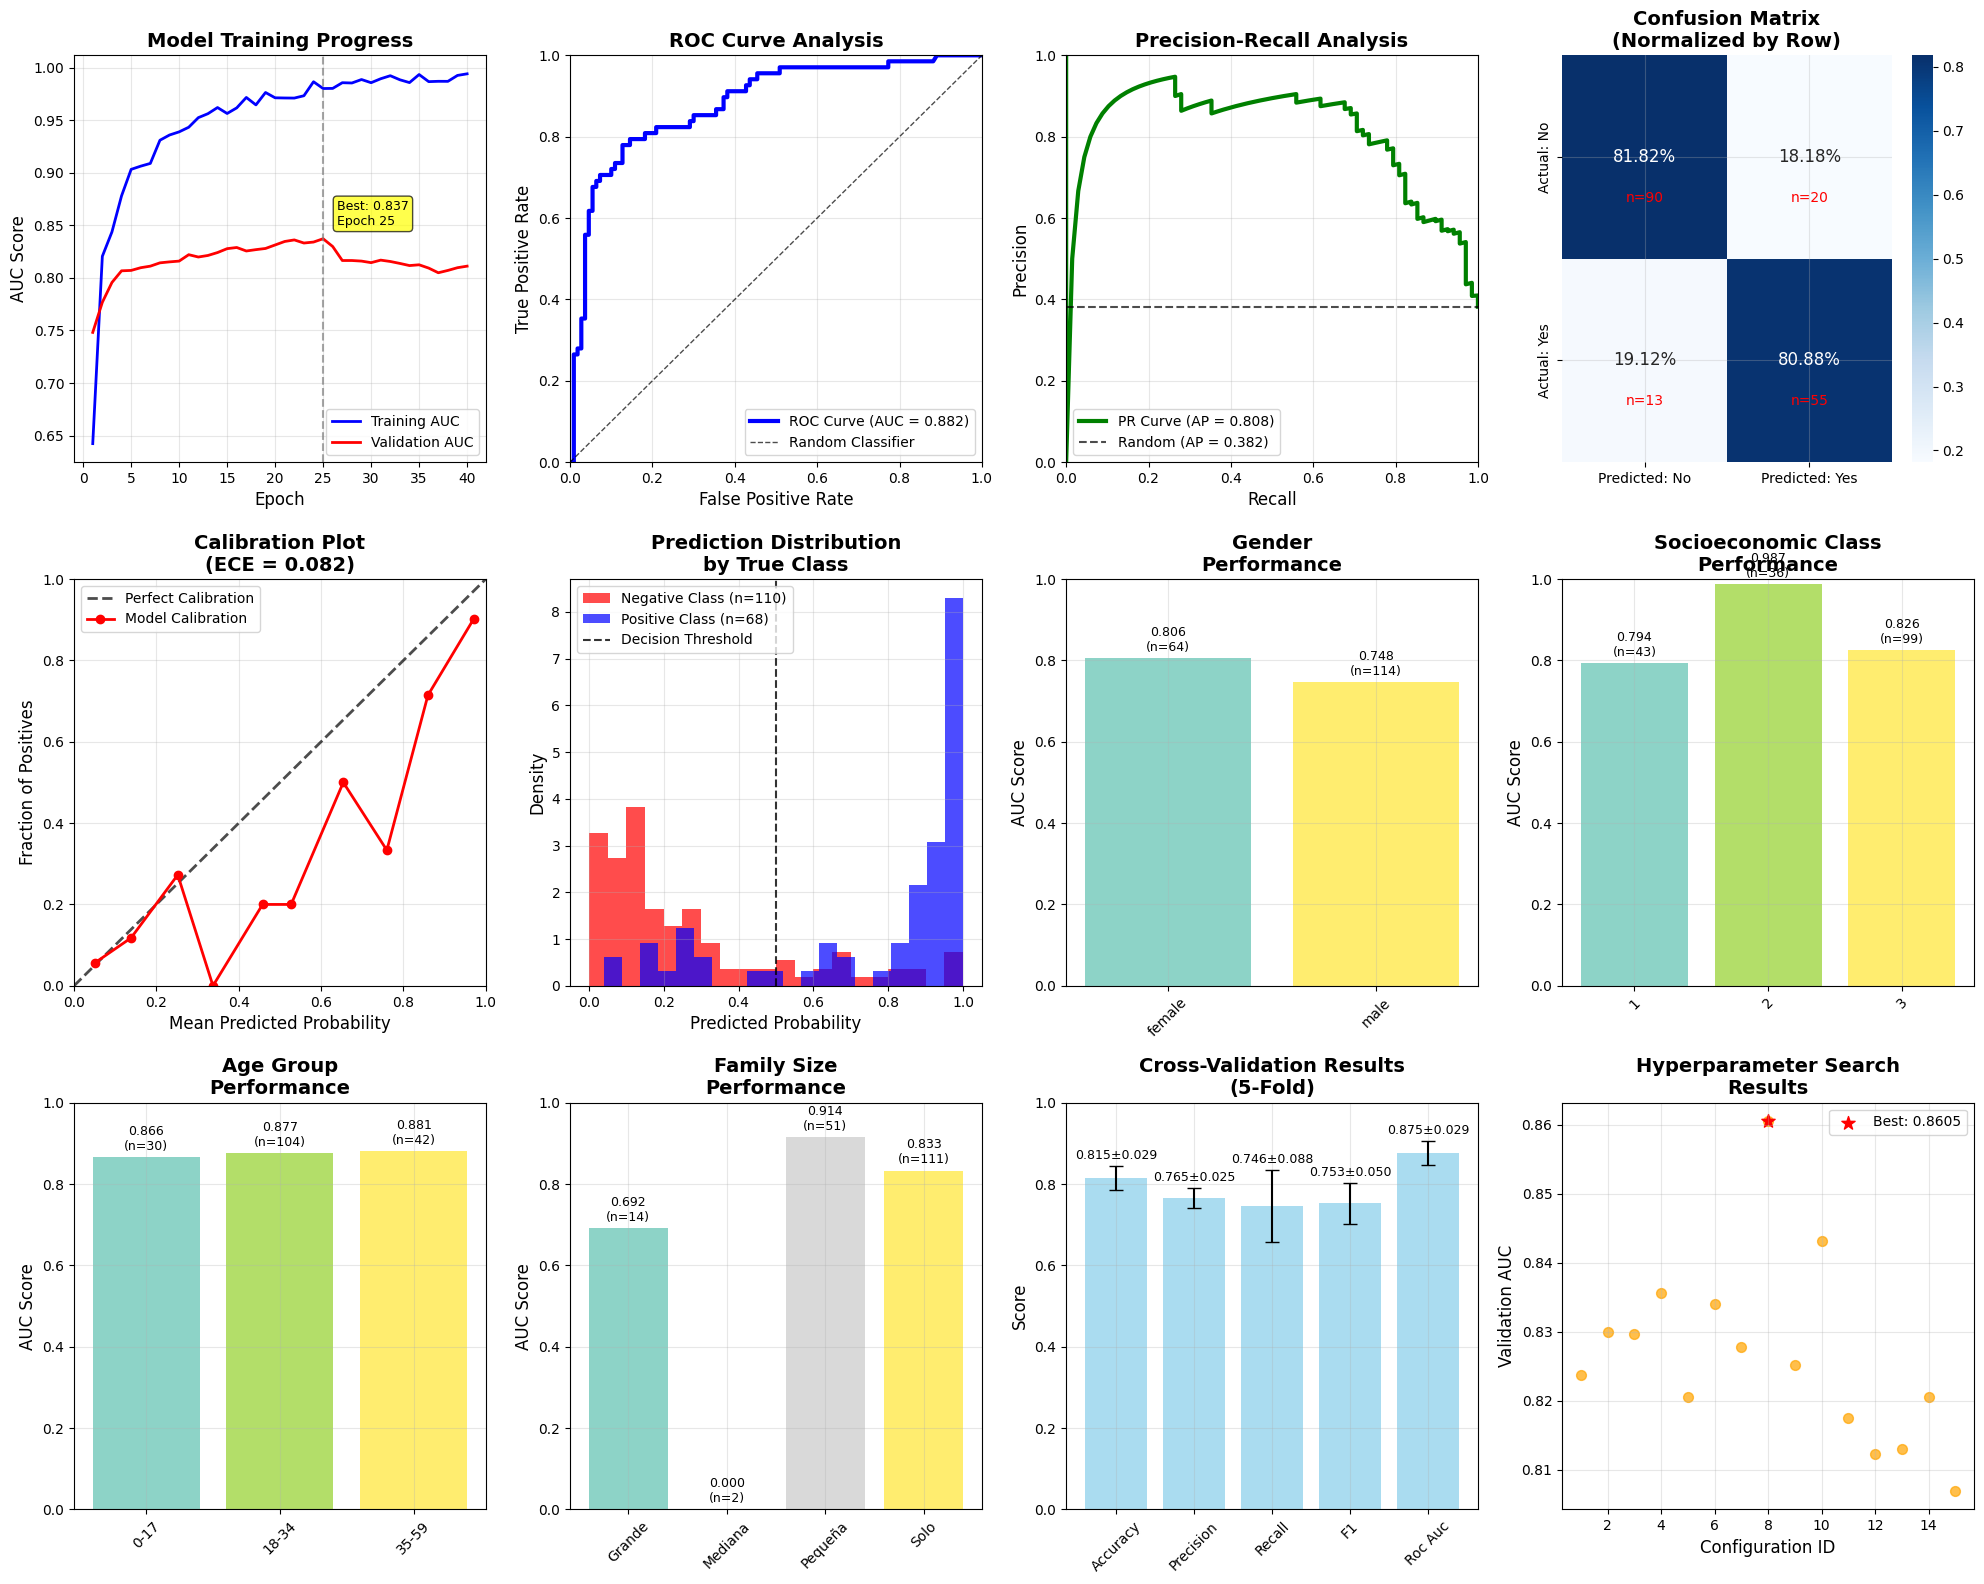


6. SAVING RESULTS
----------------------------------------
✓ Model saved: models\NeuralNetwork_Publication_20250831_170008.h5
✓ Results saved: results\NeuralNetwork_Publication_results_20250831_170008.json
✓ History saved: results\NeuralNetwork_Publication_history_20250831_170008.json

Experiment completed successfully!
Results saved with timestamp: 20250831_170008

EXPERIMENT EXECUTION COMPLETED


In [39]:
# Execute Neural Network Experiment
print("\n" + "=" * 80)
print("NEURAL NETWORK EXPERIMENT EXECUTION")
print("=" * 80)

# Initialize experiment
nn_experiment = NeuralNetworkExperiment(random_state=42)

# Execute complete experiment pipeline
experiment_results = nn_experiment.run_experiment(
    X_train_processed, 
    y_train.values,
    X_val_processed, 
    y_val.values,
    demographic_data=demo_val
)

print("\n" + "=" * 80)
print("EXPERIMENT EXECUTION COMPLETED")
print("=" * 80)

In [40]:
# Final Model Evaluation on Test Set
print("\n" + "=" * 60)
print("FINAL TEST SET EVALUATION")
print("=" * 60)

# Generate predictions on test set
test_proba = nn_experiment.best_model.predict(X_test_processed, verbose=0).ravel()
test_pred = (test_proba >= 0.5).astype(int)

# Calculate comprehensive test metrics
test_metrics = {
    'accuracy': accuracy_score(y_test, test_pred),
    'precision': precision_score(y_test, test_pred, zero_division=0),
    'recall': recall_score(y_test, test_pred, zero_division=0),
    'f1_score': f1_score(y_test, test_pred, zero_division=0),
    'roc_auc': roc_auc_score(y_test, test_proba),
    'pr_auc': average_precision_score(y_test, test_proba),
    'matthews_corrcoef': matthews_corrcoef(y_test, test_pred),
    'balanced_accuracy': balanced_accuracy_score(y_test, test_pred),
    'brier_score': brier_score_loss(y_test, test_proba)
}

# Test set demographic analysis
test_demographic_analysis = {}
for demo_var, demo_name in nn_experiment.demographic_vars.items():
    if demo_var in demo_test:
        test_demographic_analysis[demo_name] = nn_experiment._analyze_demographic_group(
            y_test.values, test_pred, test_proba, demo_test[demo_var], demo_name
        )

# Calculate test set calibration
test_calibration = nn_experiment._calculate_calibration_metrics(y_test, test_proba)

print("\nTEST SET PERFORMANCE METRICS:")
print("-" * 40)
for metric, value in test_metrics.items():
    print(f"{metric.replace('_', ' ').title():.<25} {value:.4f}")

print(f"\nTEST SET CALIBRATION:")
print("-" * 40)
print(f"Expected Calibration Error: {test_calibration['expected_calibration_error']:.4f}")
print(f"Brier Score: {test_calibration['brier_score']:.4f}")

# Confusion matrix
test_cm = confusion_matrix(y_test, test_pred)
print(f"\nTEST SET CONFUSION MATRIX:")
print("-" * 40)
print(f"                 Predicted")
print(f"              No     Yes    Total")
print(f"Actual No   {test_cm[0,0]:4d}   {test_cm[0,1]:4d}    {test_cm[0].sum():4d}")
print(f"Actual Yes  {test_cm[1,0]:4d}   {test_cm[1,1]:4d}    {test_cm[1].sum():4d}")
print(f"Total       {test_cm[:,0].sum():4d}   {test_cm[:,1].sum():4d}    {test_cm.sum():4d}")

# Demographic analysis summary
if test_demographic_analysis:
    print(f"\nTEST SET DEMOGRAPHIC ANALYSIS:")
    print("-" * 40)
    for demo_name, group_results in test_demographic_analysis.items():
        print(f"\n{demo_name}:")
        for group, metrics in group_results.items():
            if 'roc_auc' in metrics:
                print(f"  {group:12} (n={metrics['sample_size']:3d}): "
                      f"AUC={metrics['roc_auc']:.3f}, Acc={metrics['accuracy']:.3f}")
            else:
                print(f"  {group:12} (n={metrics['sample_size']:3d}): "
                      f"Acc={metrics['accuracy']:.3f} {metrics.get('note', '')}")


FINAL TEST SET EVALUATION

TEST SET PERFORMANCE METRICS:
----------------------------------------
Accuracy................. 0.7933
Precision................ 0.7105
Recall................... 0.7826
F1 Score................. 0.7448
Roc Auc.................. 0.8303
Pr Auc................... 0.7819
Matthews Corrcoef........ 0.5737
Balanced Accuracy........ 0.7913
Brier Score.............. 0.1553

TEST SET CALIBRATION:
----------------------------------------
Expected Calibration Error: 0.1243
Brier Score: 0.1553

TEST SET CONFUSION MATRIX:
----------------------------------------
                 Predicted
              No     Yes    Total
Actual No     88     22     110
Actual Yes    15     54      69
Total        103     76     179

TEST SET DEMOGRAPHIC ANALYSIS:
----------------------------------------

Gender:
  female       (n= 61): AUC=0.796, Acc=0.803
  male         (n=118): AUC=0.611, Acc=0.788

Socioeconomic Class:
  1            (n= 45): AUC=0.766, Acc=0.667
  2            (n= 3

In [41]:
# Generate Executive Summary Report
print("\n" + "=" * 80)
print("EXECUTIVE SUMMARY REPORT")
print("=" * 80)

# Extract key results
best_val_auc = experiment_results['hyperparameter_search']['best_score']
test_auc = test_metrics['roc_auc']
cv_auc_mean = experiment_results['cross_validation']['cv_statistics']['roc_auc']['mean']
cv_auc_std = experiment_results['cross_validation']['cv_statistics']['roc_auc']['std']

print(f"\n1. EXPERIMENT OVERVIEW")
print(f"   Model Architecture: Neural Network (2-layer)")
print(f"   Experiment ID: {nn_experiment.experiment_timestamp}")
print(f"   Dataset: Titanic Enhanced ({df.shape[0]} samples, {len(selected_features)} features)")
print(f"   Train/Val/Test Split: {len(X_train)}/{len(X_val)}/{len(X_test)} samples")

print(f"\n2. OPTIMAL CONFIGURATION")
best_params = experiment_results['hyperparameter_search']['best_params']
for param, value in best_params.items():
    print(f"   {param.replace('_', ' ').title()}: {value}")

print(f"\n3. MODEL PERFORMANCE")
print(f"   Cross-Validation AUC: {cv_auc_mean:.4f} ± {cv_auc_std:.4f}")
print(f"   Validation AUC: {best_val_auc:.4f}")
print(f"   Test AUC: {test_auc:.4f}")
print(f"   Test Accuracy: {test_metrics['accuracy']:.4f}")
print(f"   Test F1-Score: {test_metrics['f1_score']:.4f}")
print(f"   Matthews Correlation: {test_metrics['matthews_corrcoef']:.4f}")

print(f"\n4. MODEL CALIBRATION")
print(f"   Expected Calibration Error: {test_calibration['expected_calibration_error']:.4f}")
calibration_quality = "Excellent" if test_calibration['expected_calibration_error'] < 0.05 else \
                     "Good" if test_calibration['expected_calibration_error'] < 0.10 else \
                     "Moderate" if test_calibration['expected_calibration_error'] < 0.15 else "Poor"
print(f"   Calibration Quality: {calibration_quality}")

print(f"\n5. DEMOGRAPHIC FAIRNESS ANALYSIS")
if test_demographic_analysis:
    # Gender analysis (most critical)
    if 'Gender' in test_demographic_analysis:
        gender_results = test_demographic_analysis['Gender']
        if 'male' in gender_results and 'female' in gender_results:
            male_auc = gender_results['male'].get('roc_auc', 0)
            female_auc = gender_results['female'].get('roc_auc', 0)
            auc_gap = abs(female_auc - male_auc)
            print(f"   Gender AUC Gap: {auc_gap:.3f} (Male: {male_auc:.3f}, Female: {female_auc:.3f})")
            fairness_assessment = "Fair" if auc_gap < 0.05 else "Moderate Bias" if auc_gap < 0.10 else "Significant Bias"
            print(f"   Gender Fairness: {fairness_assessment}")

print(f"\n6. COMPUTATIONAL EFFICIENCY")
training_epochs = experiment_results['training']['final_epochs']
print(f"   Training Epochs: {training_epochs}")
print(f"   Hyperparameter Configurations Tested: {experiment_results['hyperparameter_search']['total_configurations']}")
print(f"   Cross-Validation Folds: {experiment_results['cross_validation']['n_folds']}")

print(f"\n7. MODEL INTERPRETATION")
performance_level = "Excellent" if test_auc > 0.9 else "Good" if test_auc > 0.8 else "Moderate" if test_auc > 0.7 else "Limited"
print(f"   Overall Performance: {performance_level} (AUC = {test_auc:.3f})")
print(f"   Generalization: {'Good' if abs(best_val_auc - test_auc) < 0.02 else 'Moderate' if abs(best_val_auc - test_auc) < 0.05 else 'Poor'}")
print(f"   Validation-Test Gap: {abs(best_val_auc - test_auc):.4f}")


print(f"\n" + "=" * 80)
print(f"REPORT GENERATED: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"EXPERIMENT ID: {nn_experiment.experiment_timestamp}")
print("=" * 80)


EXECUTIVE SUMMARY REPORT

1. EXPERIMENT OVERVIEW
   Model Architecture: Neural Network (2-layer)
   Experiment ID: 20250831_170008
   Dataset: Titanic Enhanced (891 samples, 22 features)
   Train/Val/Test Split: 534/178/179 samples

2. OPTIMAL CONFIGURATION
   Hidden Layers: [128, 64]
   Dropout Rate: 0.2
   Learning Rate: 0.0005
   L2 Reg: 0.0005

3. MODEL PERFORMANCE
   Cross-Validation AUC: 0.8755 ± 0.0294
   Validation AUC: 0.8605
   Test AUC: 0.8303
   Test Accuracy: 0.7933
   Test F1-Score: 0.7448
   Matthews Correlation: 0.5737

4. MODEL CALIBRATION
   Expected Calibration Error: 0.1243
   Calibration Quality: Moderate

5. DEMOGRAPHIC FAIRNESS ANALYSIS
   Gender AUC Gap: 0.185 (Male: 0.611, Female: 0.796)
   Gender Fairness: Significant Bias

6. COMPUTATIONAL EFFICIENCY
   Training Epochs: 40
   Hyperparameter Configurations Tested: 15
   Cross-Validation Folds: 5

7. MODEL INTERPRETATION
   Overall Performance: Good (AUC = 0.830)
   Generalization: Moderate
   Validation-Test 